# General fit example
Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### (1) Definition of model

Consider controlled parameter range is [-1,1]

In [2]:
# True functional dependece for data generation (triangle)

def mytrue(x):
    
    tri = x + (x>0.5)*(1-2*x) + (x<-0.5)*(-1-2*x)

    return tri

In [3]:
# Fit model - sum of terms:  1, sin(ax), cos(ax), sin(2ax), cos(2ax) ...

# Basic function (return function values only)

def myfun(x,par):

    # Scaling factor
    
    a = par[0]

    # output array
    
    val = np.zeros(x.size)

    # Constant term
    
    val = par[1]

    for ip in range(2,par.size,2):
        
        pw = int(ip/2)

        val+=par[ip]*np.sin(pw*a*x)
        val+=par[ip+1]*np.cos(pw*a*x)

    return val

In [4]:
# Full model: returns values and derivatives

def myfunder(x,par):

    # output arrays
    
    val = np.zeros(x.size)
    der = np.zeros((x.size,par.size))

    # Scaling factor (global)
    
    a = par[0]

    # Constant term (global)
    
    val = par[1]

    der[:,1] = 1
    
    for ip in range(2,par.size,2):
        
        pw = int(ip/2)

        val+=par[ip]*np.sin(pw*a*x)
        val+=par[ip+1]*np.cos(pw*a*x)

        der[:,ip] = np.sin(pw*a*x)
        der[:,ip+1] = np.cos(pw*a*x)
        
        der[:,0] += par[ip]*pw*x*np.cos(pw*a*x)
        der[:,0] -= par[ip+1]*pw*x*np.sin(pw*a*x)
        
    return val,der

### (2) Generate pseudo data to fit

In [5]:
# Considered values of x

xvec = np.linspace(-0.95,0.95,20)

# Measurement precision - assume slow variation with x

svec = np.linspace(0.02,0.03,xvec.size)
s2vec = svec*svec

# Pseudo-data

yvec = np.random.normal(mytrue(xvec),svec)


### (3) Initialize an iterative fit

In [6]:
# Number of function parameters to consider  (must be even!!!)

Nfun = 6

# Initial guess for parameters

parini = np.zeros(Nfun)
parini[0] = 6.
parini[1] = 0.1
parini[2] = 0.4
parini[3] = -0.2

# Initial function vales

fini = myfun(xvec,parini) 

# Initial printout

chi2ini = np.sum((yvec-fini)**2/s2vec)

print("\nIterative fit procedure starting from parameter values")
print(" ",parini)
print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2ini,chi2ini/xvec.size))


Iterative fit procedure starting from parameter values
  [ 6.   0.1  0.4 -0.2  0.   0. ]
  chi^2 =  7290.558   chi^2/N = 364.52792 


### (4) Iterative fit procedure

In [7]:
# Main loop

lam = 0.01       # Low value -> jump close to minimum, high value -> smaller step along gradient

dcut = 0.00001     # Required precision (distance from minimum)

chi2min = chi2ini
parmin = parini

par = parini

# History of parameter evolution

parhist = []
parhist.append(par)

Nit = 0

Cov = np.zeros((Nfun,Nfun))

dist = dcut+1

while dist > dcut :

    # work space
    
    A = np.zeros((Nfun,Nfun))
    B = np.zeros(Nfun)

    # Values and derivatives at the current point
    
    fval,fder = myfunder(xvec,par)
    
    dyvec = yvec-fval
    
    for l in range(Nfun):
        B[l] = np.sum(fder[:,l]*dyvec/s2vec)
        for k in range(Nfun):
            A[l,k] = np.sum(fder[:,l]*fder[:,k]/s2vec)

    # Do not try to jump directly to the maximum (lam = 0)

    C = np.array(A)
    for l in range(Nfun):
        C[l,l] += lam
        
    # Inverse of the matrix

    Cinv = np.linalg.inv(C)

    # Solution to the problem - required parameter change

    dpar = Cinv @ B

    # Check new parameter values
    
    parnew = par+dpar

    fnew = myfun(xvec,parnew) 

    chi2new = np.sum((yvec-fnew)**2/s2vec)

    # Distance to minimum (current step length in units of sigma, assuming current errors)

    Cov = np.linalg.inv(A)
    e2par = np.diagonal(Cov)
    dist = np.sum(dpar*dpar/e2par)
    
    Nit+=1
    print("\nIteration step ",Nit," with lambda = ",lam)
    print(" ",parnew)
    print("  chi^2 =  %8.3f   chi^2/N = %8.5f " % (chi2new,chi2new/(xvec.size-Nfun)))
    print("  distance to minimum: ",dist)
    
    if chi2new < chi2min :  # Iteration successful, fit got closer to the minimum
        lam /= 10
        chi2min = chi2new
        par = parnew
    else:                   # Iteration failed, reduce step
        lam *= 10

    parhist.append(par)     # Store step in history


Iteration step  1  with lambda =  0.01
  [ 5.21494755e+00 -8.15790797e-02 -1.65213178e-02  2.09063198e-03
 -5.78949587e-02  1.40283185e-02]
  chi^2 =  2926.016   chi^2/N = 209.00114 
  distance to minimum:  5041.600594976873

Iteration step  2  with lambda =  0.001
  [ 5.88911514 -0.04762511  0.14384168  0.06464969  0.01302072 -0.00692985]
  chi^2 =  2920.985   chi^2/N = 208.64176 
  distance to minimum:  594.5037922471103

Iteration step  3  with lambda =  0.0001
  [ 2.82134717 -0.02089761  0.04289126  0.01377859 -0.08285344 -0.0326246 ]
  chi^2 =  2659.556   chi^2/N = 189.96832 
  distance to minimum:  1293.0022201525812

Iteration step  4  with lambda =  1e-05
  [ 3.4862355   0.01256547  0.35636767 -0.02283866  0.05350105  0.01522328]
  chi^2 =   442.207   chi^2/N = 31.58625 
  distance to minimum:  1813.980723937976

Iteration step  5  with lambda =  1.0000000000000002e-06
  [ 3.06379342e+00  1.85478963e-03  3.97688037e-01  4.39979160e-03
 -5.85678647e-03  3.25352378e-03]
  chi^2 

In [8]:
# Parameter uncertainties 
# (assuming no need to recalculate Cov, even if there was a slight improvement in the last step)

epar = np.sqrt(np.diagonal(Cov))

print("\n Fit results:\n\n     par         sigma_p\n")

for ip in range(par.size):
    print("  %8.3f  +/- %6.3f " % (par[ip],epar[ip]))

# Calculate correlation matrix, including rounding

Corr = Cov

print("\n Correlation matrix\n")
for ip in range(par.size):
    for jp in range(par.size):
        Corr[ip,jp]=int(1000.*Corr[ip,jp]/epar[ip]/epar[jp]+0.5)/1000.
        
    print(Corr[ip,:])

# Fitted function

fvec = myfun(xvec,par) 

# Chi^2 printout

chi2 = np.sum((yvec-fvec)**2/s2vec)

print("\n chi^2 =  %8.3f   chi^2/Ndf = %8.5f " % (chi2,chi2/(xvec.size-Nfun)))



 Fit results:

     par         sigma_p

     3.267  +/-  0.034 
    -0.002  +/-  0.006 
     0.420  +/-  0.008 
     0.009  +/-  0.008 
    -0.024  +/-  0.010 
     0.006  +/-  0.008 

 Correlation matrix

[ 1.    -0.11   0.212  0.189 -0.578 -0.22 ]
[-0.11   1.     0.149  0.038  0.003 -0.046]
[ 0.212  0.149  1.    -0.014 -0.123 -0.141]
[ 0.189  0.038 -0.014  1.     0.015  0.057]
[-0.578  0.003 -0.123  0.015  1.     0.121]
[-0.22  -0.046 -0.141  0.057  0.121  1.   ]

 chi^2 =    41.714   chi^2/Ndf =  2.97957 


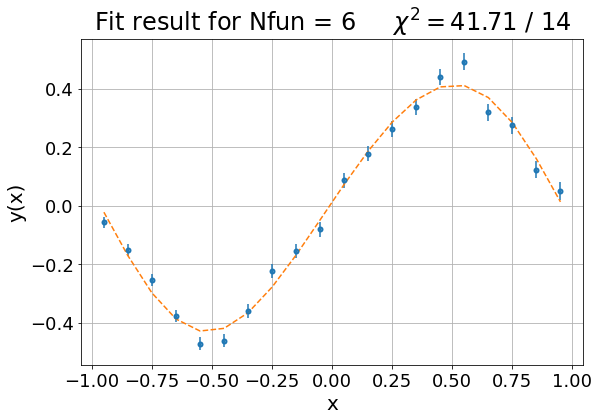

In [9]:
plt.figure(figsize=(9, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

plt.plot(xvec,fvec,'--')

plt.title('Fit result for Nfun = '+str(Nfun) +'     $\chi^{2} = $'+str(int(100*chi2+0.5)/100.)+' / '+str(xvec.size-Nfun),size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '09_fit2_'+str(Nfun)+'.png'
plt.savefig(fname)

### (5) Draw iteration history

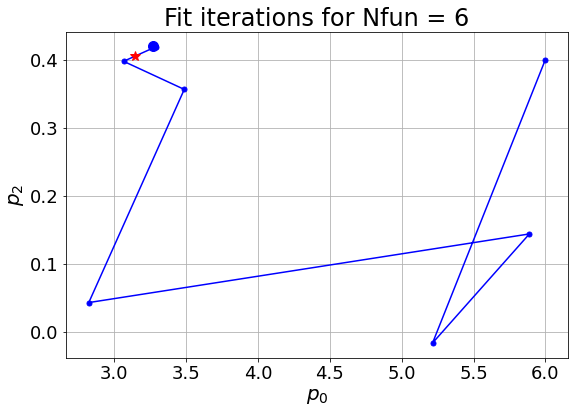

In [10]:
# Parameters to be ploted

ipx=0
ipy=2

# Expected values (from Fourier series)

Amp = 4./np.pi/np.pi;

parexp = np.array([np.pi, 0., Amp, 0., 0., 0, -Amp/9., 0., 0., 0, Amp/25., 0., 0., 0, -Amp/49., 0., 0., 0, Amp/81., 0., 0., 0,-Amp/121., 0., 0., 0])

parhist=np.array(parhist)

plt.figure(figsize=(9, 6))

plt.plot(parhist[:,ipx],parhist[:,ipy],'b-o', ms=5)

plt.plot(parhist[Nit,ipx],parhist[Nit,ipy],'b-o', ms=10)

plt.plot([parexp[ipx]],[parexp[ipy]],'r*', ms=10)

plt.title('Fit iterations for Nfun = '+str(Nfun) ,size=24)
plt.xlabel('$p_{'+str(ipx)+'}$',size=20)
plt.ylabel('$p_{'+str(ipy)+'}$',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '09_fit2_'+str(Nfun)+'_hist.png'
plt.savefig(fname)

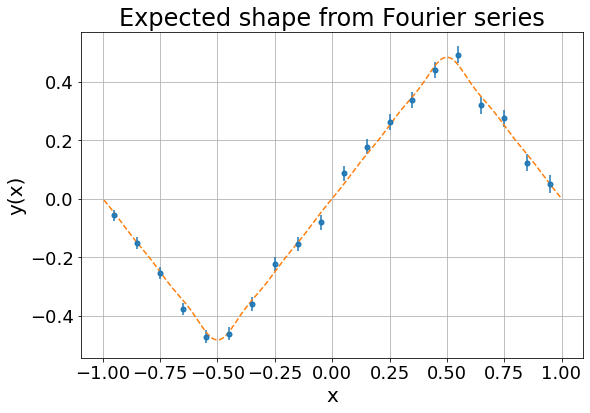

In [11]:
plt.figure(figsize=(9, 6))

plt.errorbar(xvec,yvec,svec, linestyle='none', marker='o', ms=2, mew=4)

xexp = np.linspace(-0.995,0.995,200)
fexp = myfun(xexp,parexp) 
plt.plot(xexp,fexp,'--')

plt.title('Expected shape from Fourier series',size=24)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')

fname = '09_fit2_exp.png'
plt.savefig(fname)